Homework 2

Christopher Beam

800927396

# Problem 1

### Part 1

In [1]:
TRAINING=True # Performs training or loads previous model state

In [2]:
import os
import math
import numpy as np
import time
## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()
## Progress bar
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.nn.functional as F
# Required imports
from PIL import Image
from torchvision import transforms
from torchvision import datasets
import torch.optim as optim
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from ptflops import get_model_complexity_info

C:\Users\Grey\AppData\Local\Temp/ipykernel_7464/1197456983.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [3]:
#conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch
import torch
print("Using torch", torch.__version__)

Using torch 1.10.1


In [4]:
torch.manual_seed(42) # Setting the seed

In [5]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? True


In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [7]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.determinstic = True
    torch.backends.cudnn.benchmark = False

In [8]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
data_path = '../Data/Dataset/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True,transform=transforms.ToTensor())
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True,transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [9]:
imgs = torch.stack([img_t for img_t, _ in cifar10], dim=3)
imgs_val = torch.stack([img_t for img_t,_ in cifar10_val], dim=3)
train_mean = imgs.view(3,-1).mean(dim=1)
train_std = imgs.view(3,-1).std(dim=1)
val_mean = imgs_val.view(3,-1).mean(dim=1)
val_std = imgs_val.view(3,-1).std(dim=1)

In [10]:
norm_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean,train_std)
]))
norm_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(val_mean,val_std)
]))

In [11]:
train_loader = torch.utils.data.DataLoader(norm_cifar10, batch_size=1000, shuffle=True)
val_loader = torch.utils.data.DataLoader(norm_cifar10_val, batch_size=1000, shuffle=True)

In [12]:
class Netp1p1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32,10)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [13]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_load, val_load):
    temp_t = []
    temp_v = []
    tic = time.time()
    for epoch in tqdm(range(1, n_epochs + 1)):
        total = 0
        correct = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
        
            batch_size = imgs.shape[0]
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
        
                batch_size = imgs.shape[0]
                outputs = model(imgs)
                _, predicted = torch.max(outputs,dim=1)
                total += labels.shape[0]
                correct += int((predicted==labels).sum())
        
        if epoch % 10 == 0:
            print("Epoch %d, Train Loss: %f, Val Accuracy: %f" % (epoch, float(loss), float(correct/total)))
        temp_t.append(float(loss))
        temp_v.append(float(correct/total))
    print("Time to complete training: %f" % float(time.time()-tic))
    fig = plt.figure(dpi=600)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(range(1,n_epochs+1), temp_t, 'ro')
    fig2 = plt.figure(dpi=600)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(range(1,n_epochs+1), temp_v,'bo')

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10, Train Loss: 1.901287, Val Accuracy: 0.337100
Epoch 20, Train Loss: 1.811497, Val Accuracy: 0.386800
Epoch 30, Train Loss: 1.664419, Val Accuracy: 0.419900
Epoch 40, Train Loss: 1.575302, Val Accuracy: 0.447300
Epoch 50, Train Loss: 1.522674, Val Accuracy: 0.468600
Epoch 60, Train Loss: 1.512313, Val Accuracy: 0.485700
Epoch 70, Train Loss: 1.429659, Val Accuracy: 0.500100
Epoch 80, Train Loss: 1.333321, Val Accuracy: 0.519000
Epoch 90, Train Loss: 1.344597, Val Accuracy: 0.527000
Epoch 100, Train Loss: 1.337721, Val Accuracy: 0.539100
Epoch 110, Train Loss: 1.262984, Val Accuracy: 0.548700
Epoch 120, Train Loss: 1.193732, Val Accuracy: 0.560500
Epoch 130, Train Loss: 1.178505, Val Accuracy: 0.566900
Epoch 140, Train Loss: 1.143577, Val Accuracy: 0.576000
Epoch 150, Train Loss: 1.140870, Val Accuracy: 0.579800
Epoch 160, Train Loss: 1.150909, Val Accuracy: 0.586100
Epoch 170, Train Loss: 1.131458, Val Accuracy: 0.591300
Epoch 180, Train Loss: 1.086318, Val Accuracy: 0.601300
E

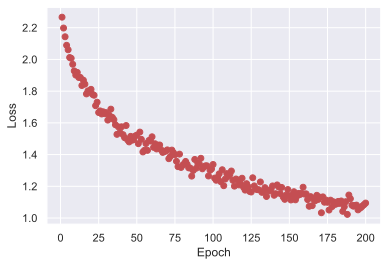

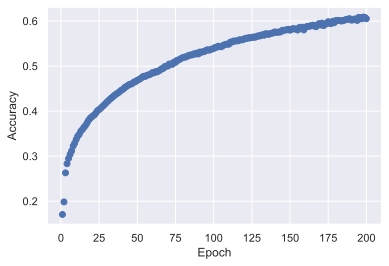

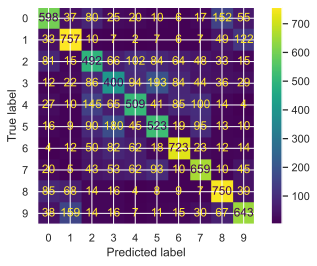

In [14]:
if TRAINING is True:
    modelp1p1 = Netp1p1().to(device)
    optimizer = optim.SGD(modelp1p1.parameters(), lr=1e-2)
    loss_fn = nn.CrossEntropyLoss().to(device)

    training_loop(
        n_epochs=200,
        optimizer=optimizer,
        model=modelp1p1,
        loss_fn=loss_fn,
        train_load=train_loader,
        val_load=val_loader
    )

    gt_array = []
    pred_array = []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            batch_size = imgs.shape[0]
            outputs = modelp1p1(imgs)
            _, predicted = torch.max(outputs,dim=1)
            gt_array.append(labels)
            pred_array.append(predicted)

    gt_array = torch.concat(gt_array)
    pred_array = torch.concat(pred_array)
    ConfusionMatrixDisplay(confusion_matrix(gt_array.to('cpu'),pred_array.to('cpu'))).plot()
    state_dict = modelp1p1.state_dict()
    torch.save(state_dict, "../Data/Homework3/modelp1p1.tar")
    
if TRAINING is False:
    state_dict = torch.load("../Data/Homework3/modelp1p1.tar")
    modelp1p1 = Netp1p1().to(device)
    modelp1p1.load_state_dict(state_dict)
    
    gt_array = []
    pred_array = []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            batch_size = imgs.shape[0]
            outputs = modelp1p1(imgs)
            _, predicted = torch.max(outputs,dim=1)
            gt_array.append(labels)
            pred_array.append(predicted)

    gt_array = torch.concat(gt_array)
    pred_array = torch.concat(pred_array)
    ConfusionMatrixDisplay(confusion_matrix(gt_array.to('cpu'),pred_array.to('cpu'))).plot()
    

In [15]:
# Calculate the MACs and size of the resnet model
macs, params = get_model_complexity_info(modelp1p1, (3, 32, 32), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Netp1p1(
  0.018 M, 100.000% Params, 0.001 GMac, 100.000% MACs, 
  (conv1): Conv2d(0.0 M, 2.441% Params, 0.0 GMac, 59.389% MACs, 3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(0.001 M, 6.320% Params, 0.0 GMac, 38.444% MACs, 16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(0.016 M, 89.441% Params, 0.0 GMac, 2.125% MACs, in_features=512, out_features=32, bias=True)
  (fc2): Linear(0.0 M, 1.798% Params, 0.0 GMac, 0.043% MACs, in_features=32, out_features=10, bias=True)
)
Computational complexity:       0.0 GMac
Number of parameters:           18.35 k 


### Part 2

In [16]:
class Netp1p2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * 8, 32)
        self.fc2 = nn.Linear(32,10)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = F.max_pool2d(torch.tanh(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10, Train Loss: 2.128633, Val Accuracy: 0.248400
Epoch 20, Train Loss: 1.964334, Val Accuracy: 0.297200
Epoch 30, Train Loss: 1.915728, Val Accuracy: 0.329800
Epoch 40, Train Loss: 1.786969, Val Accuracy: 0.367800
Epoch 50, Train Loss: 1.687099, Val Accuracy: 0.401300
Epoch 60, Train Loss: 1.572001, Val Accuracy: 0.431600
Epoch 70, Train Loss: 1.494644, Val Accuracy: 0.452700
Epoch 80, Train Loss: 1.439229, Val Accuracy: 0.476100
Epoch 90, Train Loss: 1.382169, Val Accuracy: 0.495500
Epoch 100, Train Loss: 1.318147, Val Accuracy: 0.510200
Epoch 110, Train Loss: 1.327597, Val Accuracy: 0.519200
Epoch 120, Train Loss: 1.301465, Val Accuracy: 0.531300
Epoch 130, Train Loss: 1.281496, Val Accuracy: 0.544200
Epoch 140, Train Loss: 1.216625, Val Accuracy: 0.554800
Epoch 150, Train Loss: 1.224435, Val Accuracy: 0.565600
Epoch 160, Train Loss: 1.128944, Val Accuracy: 0.571600
Epoch 170, Train Loss: 1.178574, Val Accuracy: 0.578800
Epoch 180, Train Loss: 1.133757, Val Accuracy: 0.585400
E

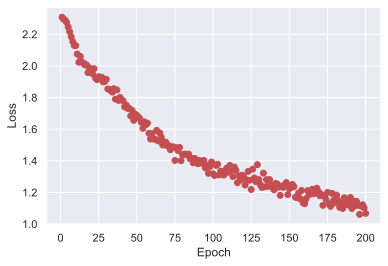

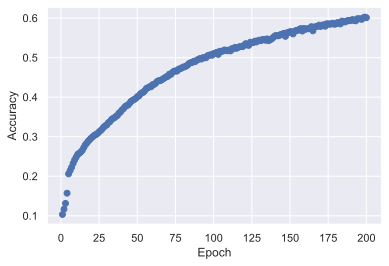

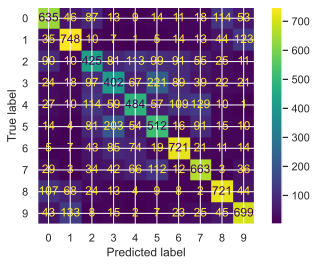

In [17]:
if TRAINING is True:
    modelp1p2 = Netp1p2().to(device)
    optimizer = optim.SGD(modelp1p2.parameters(), lr=1e-2)
    loss_fn = nn.CrossEntropyLoss().to(device)

    training_loop(
        n_epochs=200,
        optimizer=optimizer,
        model=modelp1p2,
        loss_fn=loss_fn,
        train_load=train_loader,
        val_load=val_loader
    )

    gt_array = []
    pred_array = []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            batch_size = imgs.shape[0]
            outputs = modelp1p2(imgs)
            _, predicted = torch.max(outputs,dim=1)
            gt_array.append(labels)
            pred_array.append(predicted)

    gt_array = torch.concat(gt_array)
    pred_array = torch.concat(pred_array)
    ConfusionMatrixDisplay(confusion_matrix(gt_array.to('cpu'),pred_array.to('cpu'))).plot()
    state_dict = modelp1p2.state_dict()
    torch.save(state_dict, "../Data/Homework3/modelp1p2.tar")
    
if TRAINING is False:
    state_dict = torch.load("../Data/Homework3/modelp1p2.tar")
    modelp1p2 = Netp1p2().to(device)
    modelp1p2.load_state_dict(state_dict)
    
    gt_array = []
    pred_array = []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            batch_size = imgs.shape[0]
            outputs = modelp1p2(imgs)
            _, predicted = torch.max(outputs,dim=1)
            gt_array.append(labels)
            pred_array.append(predicted)

    gt_array = torch.concat(gt_array)
    pred_array = torch.concat(pred_array)
    ConfusionMatrixDisplay(confusion_matrix(gt_array.to('cpu'),pred_array.to('cpu'))).plot()
    

In [18]:
# Calculate the MACs and size of the resnet model
macs, params = get_model_complexity_info(modelp1p2, (3, 32, 32), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Netp1p2(
  0.011 M, 100.000% Params, 0.002 GMac, 100.000% MACs, 
  (conv1): Conv2d(0.001 M, 8.045% Params, 0.001 GMac, 42.088% MACs, 3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(0.005 M, 41.516% Params, 0.001 GMac, 54.302% MACs, 32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(0.001 M, 10.415% Params, 0.0 GMac, 3.406% MACs, 16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(0.004 M, 37.062% Params, 0.0 GMac, 0.189% MACs, in_features=128, out_features=32, bias=True)
  (fc2): Linear(0.0 M, 2.963% Params, 0.0 GMac, 0.015% MACs, in_features=32, out_features=10, bias=True)
)
Computational complexity:       0.0 GMac
Number of parameters:           11.14 k 


# Problem 2

### Part 1

In [19]:
class ResBlock(nn.Module):
    def __init__(self,n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
        
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [20]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)])
        )
        self.fc1 = nn.Linear(8*8*n_chans1, 32)
        self.fc2 = nn.Linear(32,10)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10, Train Loss: 1.427916, Val Accuracy: 0.468000
Epoch 20, Train Loss: 1.218387, Val Accuracy: 0.539900
Epoch 30, Train Loss: 1.103249, Val Accuracy: 0.595500
Epoch 40, Train Loss: 0.980145, Val Accuracy: 0.593000
Epoch 50, Train Loss: 0.975365, Val Accuracy: 0.635900
Epoch 60, Train Loss: 0.896624, Val Accuracy: 0.646500
Epoch 70, Train Loss: 0.884883, Val Accuracy: 0.651500
Epoch 80, Train Loss: 0.763915, Val Accuracy: 0.667400
Epoch 90, Train Loss: 0.695955, Val Accuracy: 0.681900
Epoch 100, Train Loss: 0.718625, Val Accuracy: 0.683700
Epoch 110, Train Loss: 0.683635, Val Accuracy: 0.684500
Epoch 120, Train Loss: 0.693677, Val Accuracy: 0.678100
Epoch 130, Train Loss: 0.637989, Val Accuracy: 0.675100
Epoch 140, Train Loss: 0.642251, Val Accuracy: 0.694500
Epoch 150, Train Loss: 0.607631, Val Accuracy: 0.680700
Epoch 160, Train Loss: 0.619468, Val Accuracy: 0.686500
Epoch 170, Train Loss: 0.563257, Val Accuracy: 0.697900
Epoch 180, Train Loss: 0.611053, Val Accuracy: 0.686700
E

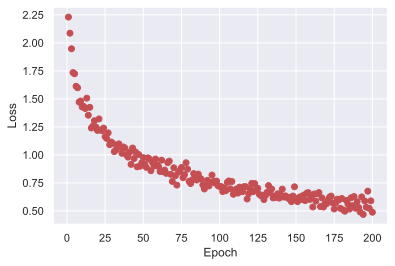

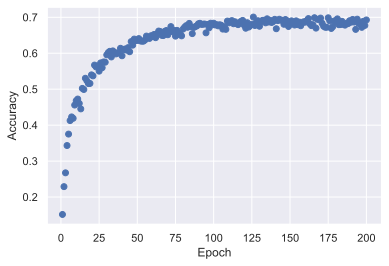

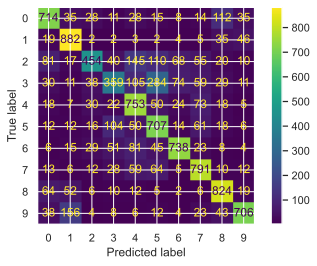

In [21]:
if TRAINING is True:
    modelp2p1 = NetResDeep().to(device)
    optimizer = optim.SGD(modelp2p1.parameters(), lr=1e-2)
    loss_fn = nn.CrossEntropyLoss().to(device)

    training_loop(
        n_epochs=200,
        optimizer=optimizer,
        model=modelp2p1,
        loss_fn=loss_fn,
        train_load=train_loader,
        val_load=val_loader
    )

    gt_array = []
    pred_array = []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            batch_size = imgs.shape[0]
            outputs = modelp2p1(imgs)
            _, predicted = torch.max(outputs,dim=1)
            gt_array.append(labels)
            pred_array.append(predicted)

    gt_array = torch.concat(gt_array)
    pred_array = torch.concat(pred_array)
    ConfusionMatrixDisplay(confusion_matrix(gt_array.to('cpu'),pred_array.to('cpu'))).plot()
    state_dict = modelp2p1.state_dict()
    torch.save(state_dict, "../Data/Homework3/modelp2p1.tar")
    
if TRAINING is False:
    state_dict = torch.load("../Data/Homework3/modelp2p1.tar")
    modelp2p1 = NetResDeep().to(device)
    modelp2p1.load_state_dict(state_dict)
    
    gt_array = []
    pred_array = []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            batch_size = imgs.shape[0]
            outputs = modelp2p1(imgs)
            _, predicted = torch.max(outputs,dim=1)
            gt_array.append(labels)
            pred_array.append(predicted)

    gt_array = torch.concat(gt_array)
    pred_array = torch.concat(pred_array)
    ConfusionMatrixDisplay(confusion_matrix(gt_array.to('cpu'),pred_array.to('cpu'))).plot()
    

In [22]:
# Calculate the MACs and size of the resnet model
macs, params = get_model_complexity_info(modelp2p1, (3, 32, 32), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

NetResDeep(
  0.076 M, 100.000% Params, 0.025 GMac, 100.000% MACs, 
  (conv1): Conv2d(0.001 M, 1.178% Params, 0.001 GMac, 3.709% MACs, 3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (resblocks): Sequential(
    0.009 M, 12.199% Params, 0.024 GMac, 96.025% MACs, 
    (0): ResBlock(
      0.009 M, 12.199% Params, 0.024 GMac, 96.025% MACs, 
      (conv): Conv2d(0.009 M, 12.115% Params, 0.024 GMac, 95.363% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(0.0 M, 0.084% Params, 0.0 GMac, 0.662% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      0.009 M, 12.199% Params, 0.024 GMac, 96.025% MACs, 
      (conv): Conv2d(0.009 M, 12.115% Params, 0.024 GMac, 95.363% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(0.0 M, 0.084% Params, 0.0 GMac, 0.662% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_

### Part 2

#### Weight Penalize

In [23]:
class ResBlockNonBatch(nn.Module):
    def __init__(self,n_chans):
        super(ResBlockNonBatch, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        
    def forward(self, x):
        out = self.conv(x)
        out = torch.relu(out)
        return out + x

In [24]:
class NetResDeepNonBatch(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlockNonBatch(n_chans=n_chans1)])
        )
        self.fc1 = nn.Linear(8*8*n_chans1, 32)
        self.fc2 = nn.Linear(32,10)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [25]:
def training_loopWeight(n_epochs, optimizer, model, loss_fn, train_load, val_load):
    temp_t = []
    temp_v = []
    tic = time.time()
    for epoch in tqdm(range(1, n_epochs + 1)):
        total = 0
        correct = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
        
            batch_size = imgs.shape[0]
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
        
                batch_size = imgs.shape[0]
                outputs = model(imgs)
                _, predicted = torch.max(outputs,dim=1)
                total += labels.shape[0]
                correct += int((predicted==labels).sum())
        
        if epoch % 10 == 0:
            print("Epoch %d, Train Loss: %f, Val Accuracy: %f" % (epoch, float(loss), float(correct/total)))
        temp_t.append(float(loss))
        temp_v.append(float(correct/total))
    print("Time to complete training: %f" % float(time.time()-tic))
    fig = plt.figure(dpi=600)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(range(1,n_epochs+1), temp_t, 'ro')
    fig2 = plt.figure(dpi=600)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(range(1,n_epochs+1), temp_v,'bo')

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10, Train Loss: 1.332820, Val Accuracy: 0.501000
Epoch 20, Train Loss: 1.172058, Val Accuracy: 0.573400
Epoch 30, Train Loss: 1.071924, Val Accuracy: 0.609300
Epoch 40, Train Loss: 1.075761, Val Accuracy: 0.619600
Epoch 50, Train Loss: 0.941245, Val Accuracy: 0.659500
Epoch 60, Train Loss: 0.849617, Val Accuracy: 0.670600
Epoch 70, Train Loss: 0.800532, Val Accuracy: 0.666700
Epoch 80, Train Loss: 0.964399, Val Accuracy: 0.630600
Epoch 90, Train Loss: 0.711695, Val Accuracy: 0.674800
Epoch 100, Train Loss: 0.755927, Val Accuracy: 0.670800
Epoch 110, Train Loss: 0.689937, Val Accuracy: 0.668800
Epoch 120, Train Loss: 0.621340, Val Accuracy: 0.670100
Epoch 130, Train Loss: 0.622070, Val Accuracy: 0.668100
Epoch 140, Train Loss: 0.724590, Val Accuracy: 0.638800
Epoch 150, Train Loss: 0.595835, Val Accuracy: 0.669700
Epoch 160, Train Loss: 0.529002, Val Accuracy: 0.662800
Epoch 170, Train Loss: 0.511117, Val Accuracy: 0.668500
Epoch 180, Train Loss: 0.633795, Val Accuracy: 0.634200
E

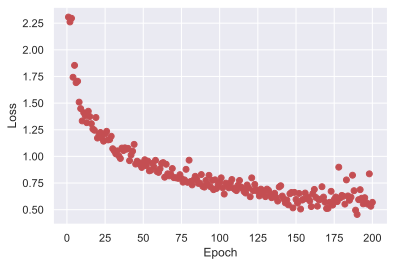

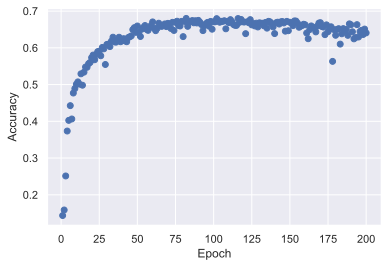

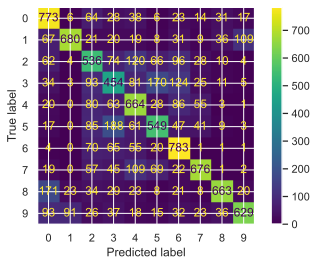

In [26]:
 if TRAINING is True:
    modelp2p2Weight = NetResDeepNonBatch().to(device)
    optimizer = optim.SGD(modelp2p2Weight.parameters(), lr=1e-2)
    loss_fn = nn.CrossEntropyLoss().to(device)

    training_loopWeight(
        n_epochs=200,
        optimizer=optimizer,
        model=modelp2p2Weight,
        loss_fn=loss_fn,
        train_load=train_loader,
        val_load=val_loader
    )

    gt_array = []
    pred_array = []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            batch_size = imgs.shape[0]
            outputs = modelp2p2Weight(imgs)
            _, predicted = torch.max(outputs,dim=1)
            gt_array.append(labels)
            pred_array.append(predicted)

    gt_array = torch.concat(gt_array)
    pred_array = torch.concat(pred_array)
    ConfusionMatrixDisplay(confusion_matrix(gt_array.to('cpu'),pred_array.to('cpu'))).plot()
    state_dict = modelp2p2Weight.state_dict()
    torch.save(state_dict, "../Data/Homework3/modelp2p2Weight.tar")
    
if TRAINING is False:
    state_dict = torch.load("../Data/Homework3/modelp2p2Weight.tar")
    modelp2p2Weight = NetResDeepNonBatch().to(device)
    modelp2p2Weight.load_state_dict(state_dict)
    
    gt_array = []
    pred_array = []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            batch_size = imgs.shape[0]
            outputs = modelp2p2Weight(imgs)
            _, predicted = torch.max(outputs,dim=1)
            gt_array.append(labels)
            pred_array.append(predicted)

    gt_array = torch.concat(gt_array)
    pred_array = torch.concat(pred_array)
    ConfusionMatrixDisplay(confusion_matrix(gt_array.to('cpu'),pred_array.to('cpu'))).plot()
    

In [27]:
# Calculate the MACs and size of the resnet model
macs, params = get_model_complexity_info(modelp2p2Weight, (3, 32, 32), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

NetResDeepNonBatch(
  0.076 M, 100.000% Params, 0.025 GMac, 100.000% MACs, 
  (conv1): Conv2d(0.001 M, 1.179% Params, 0.001 GMac, 3.733% MACs, 3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (resblocks): Sequential(
    0.009 M, 12.125% Params, 0.024 GMac, 95.999% MACs, 
    (0): ResBlockNonBatch(
      0.009 M, 12.125% Params, 0.024 GMac, 95.999% MACs, 
      (conv): Conv2d(0.009 M, 12.125% Params, 0.024 GMac, 95.999% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): ResBlockNonBatch(
      0.009 M, 12.125% Params, 0.024 GMac, 95.999% MACs, 
      (conv): Conv2d(0.009 M, 12.125% Params, 0.024 GMac, 95.999% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): ResBlockNonBatch(
      0.009 M, 12.125% Params, 0.024 GMac, 95.999% MACs, 
      (conv): Conv2d(0.009 M, 12.125% Params, 0.024 GMac, 95.999% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (3): ResBl

#### Dropout

In [28]:
class ResBlockDropout(nn.Module):
    def __init__(self,n_chans):
        super(ResBlockDropout, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.conv_dropout = nn.Dropout2d(p=0.3)
        
    def forward(self, x):
        out = self.conv(x)
        out = torch.relu(out)
        out = self.conv_dropout(out)
        return out + x

In [29]:
class NetResDeepDropout(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.3)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlockDropout(n_chans=n_chans1)])
        )
        self.fc1 = nn.Linear(8*8*n_chans1, 32)
        self.fc2 = nn.Linear(32,10)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10, Train Loss: 1.659981, Val Accuracy: 0.449100
Epoch 20, Train Loss: 1.404238, Val Accuracy: 0.517200
Epoch 30, Train Loss: 1.236915, Val Accuracy: 0.560000
Epoch 40, Train Loss: 1.192085, Val Accuracy: 0.569800
Epoch 50, Train Loss: 1.043272, Val Accuracy: 0.584000
Epoch 60, Train Loss: 1.018435, Val Accuracy: 0.606500
Epoch 70, Train Loss: 1.113963, Val Accuracy: 0.604500
Epoch 80, Train Loss: 0.999444, Val Accuracy: 0.607400
Epoch 90, Train Loss: 0.973007, Val Accuracy: 0.618700
Epoch 100, Train Loss: 0.922468, Val Accuracy: 0.634000
Epoch 110, Train Loss: 0.867027, Val Accuracy: 0.628500
Epoch 120, Train Loss: 0.845385, Val Accuracy: 0.623800
Epoch 130, Train Loss: 0.825136, Val Accuracy: 0.637000
Epoch 140, Train Loss: 0.841531, Val Accuracy: 0.630700
Epoch 150, Train Loss: 0.817951, Val Accuracy: 0.642200
Epoch 160, Train Loss: 0.779890, Val Accuracy: 0.643900
Epoch 170, Train Loss: 0.791202, Val Accuracy: 0.641800
Epoch 180, Train Loss: 0.864236, Val Accuracy: 0.640300
E

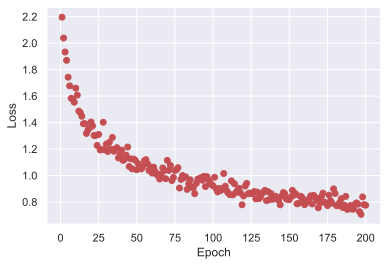

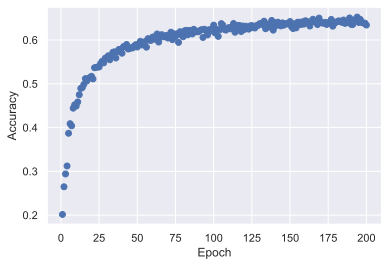

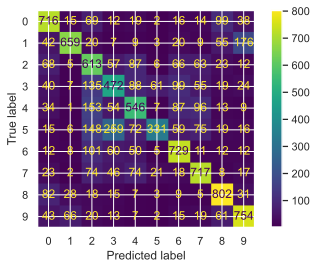

In [30]:
if TRAINING is True:
    modelp2p2Dropout = NetResDeepDropout().to(device)
    optimizer = optim.SGD(modelp2p2Dropout.parameters(), lr=1e-2)
    loss_fn = nn.CrossEntropyLoss().to(device)

    training_loop(
        n_epochs=200,
        optimizer=optimizer,
        model=modelp2p2Dropout,
        loss_fn=loss_fn,
        train_load=train_loader,
        val_load=val_loader
    )

    gt_array = []
    pred_array = []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            batch_size = imgs.shape[0]
            outputs = modelp2p2Dropout(imgs)
            _, predicted = torch.max(outputs,dim=1)
            gt_array.append(labels)
            pred_array.append(predicted)

    gt_array = torch.concat(gt_array)
    pred_array = torch.concat(pred_array)
    ConfusionMatrixDisplay(confusion_matrix(gt_array.to('cpu'),pred_array.to('cpu'))).plot()
    state_dict = modelp2p2Dropout.state_dict()
    torch.save(state_dict, "../Data/Homework3/modelp2p2Dropout.tar")
    
if TRAINING is False:
    state_dict = torch.load("../Data/Homework3/modelp2p2Dropout.tar")
    modelp2p2Dropout = NetResDeepDropout().to(device)
    modelp2p2Dropout.load_state_dict(state_dict)
    
    gt_array = []
    pred_array = []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            batch_size = imgs.shape[0]
            outputs = modelp2p2Dropout(imgs)
            _, predicted = torch.max(outputs,dim=1)
            gt_array.append(labels)
            pred_array.append(predicted)

    gt_array = torch.concat(gt_array)
    pred_array = torch.concat(pred_array)
    ConfusionMatrixDisplay(confusion_matrix(gt_array.to('cpu'),pred_array.to('cpu'))).plot()
    

In [31]:
# Calculate the MACs and size of the resnet model
macs, params = get_model_complexity_info(modelp2p2Dropout, (3, 32, 32), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

NetResDeepDropout(
  0.076 M, 100.000% Params, 0.025 GMac, 100.000% MACs, 
  (conv1): Conv2d(0.001 M, 1.179% Params, 0.001 GMac, 3.733% MACs, 3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_dropout): Dropout2d(0.0 M, 0.000% Params, 0.0 GMac, 0.000% MACs, p=0.3, inplace=False)
  (resblocks): Sequential(
    0.009 M, 12.125% Params, 0.024 GMac, 95.999% MACs, 
    (0): ResBlockDropout(
      0.009 M, 12.125% Params, 0.024 GMac, 95.999% MACs, 
      (conv): Conv2d(0.009 M, 12.125% Params, 0.024 GMac, 95.999% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv_dropout): Dropout2d(0.0 M, 0.000% Params, 0.0 GMac, 0.000% MACs, p=0.3, inplace=False)
    )
    (1): ResBlockDropout(
      0.009 M, 12.125% Params, 0.024 GMac, 95.999% MACs, 
      (conv): Conv2d(0.009 M, 12.125% Params, 0.024 GMac, 95.999% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv_dropout): Dropout2d(0.0 M, 0.000% Params, 0.0 GMac